In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pettingzoo.mpe import simple_speaker_listener_v4

def make_env():
    env = simple_speaker_listener_v4.parallel_env(continuous_actions=False, render_mode="rgb_array", max_cycles=25)
    env.reset()
    return env

def make_env_human():
    env = simple_speaker_listener_v4.parallel_env(continuous_actions=False, render_mode="human", max_cycles=25)
    env.reset()
    return env

# Test the environment
env = make_env()
print("Agents:", env.agents)  # ['speaker_0', 'listener_0']

Agents: ['speaker_0', 'listener_0']


# Hyperparameters

In [31]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Agent dimensions
speaker_obs_dim = 3     #[goal_id]
listener_obs_dim = 11 #[self_vel, all_landmark_rel_positions, communication]

speaker_act_dim = 3 # [say_0, say_1, say_2, say_3, say_4, say_5, say_6, say_7, say_8, say_9]
listener_act_dim = 5 # [no_action, move_left, move_right, move_down, move_up]

# Two layers network, applied for discriminator, policy and value network
all_hid_dim = 64

all_agents = {"speaker_0", "listener_0"}

obs_dims = {
    "speaker_0": speaker_obs_dim,
    "listener_0": listener_obs_dim
}

act_dims = {
    "speaker_0": speaker_act_dim,
    "listener_0": listener_act_dim
}

hid_dims = {
    "speaker_0": all_hid_dim,
    "listener_0": all_hid_dim
}

# Expert Demonstrations
Load the expert policy from paper Inverse Factorized Soft Q-Learning for Cooperative Multi-agent Imitation Learning


In [32]:
env = make_env()

In [45]:
import torch


# Load the expert policy
expert_policies = torch.jit.load("Expert_data/simple_speaker_listener.pt").to(device)
expert_policies.eval()

# Try to retrieve h_dim from the policy, fallback to 128
try:
    h_dim = expert_policies.h_dim
    print(f"Retrieved h_dim: {h_dim}")
except AttributeError:
    h_dim = 128  # From error message
    print("h_dim not accessible, using 128")

def expert_policy(obs, rnn_actor, deterministic=True):
    with torch.no_grad():
        # Convert observations to tensors
        obs_speaker = torch.FloatTensor(obs["speaker_0"]).to(device)
        obs_listener = torch.FloatTensor(obs["listener_0"]).to(device)
        # Pad speaker's observation (3) to match listener’s (11)
        obs_speaker_padded = torch.nn.functional.pad(obs_speaker, (0, 11 - 3))
        obs_batch = torch.stack([obs_speaker_padded, obs_listener], dim=0)
        
        # Define masks and available actions
        masks = torch.ones((2, 1), dtype=torch.bool, device=device)  # For 2 agents
        avails = torch.ones((2, 5), dtype=torch.float32, device=device)  # Assuming 5 actions per agent
        
        # Forward pass through the policy
        actions, _, new_rnn_actor = expert_policies._forward(
            obs_batch, rnn_actor, masks, avails, deterministic
        )
        actions_dict = {
            "speaker_0": actions[0].item(),
            "listener_0": actions[1].item()
        }
        return actions_dict, new_rnn_actor

def generate_expert_data(num_episodes=50):
    env = make_env()  # Assuming this is defined elsewhere
    expert_data = {agent: {"states": [], "actions": []} for agent in env.agents}

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        # Initialize rnn_actor with shape (n_agents, 1, h_dim) on device
        rnn_actor = torch.zeros((2, 1, h_dim), device=device)

        while env.agents:
            actions, rnn_actor = expert_policy(obs, rnn_actor, deterministic=True)
            for agent in env.agents:
                expert_data[agent]["states"].append(obs[agent])
                expert_data[agent]["actions"].append(actions[agent])
            obs, rewards, terminations, truncations, infos = env.step(actions)

    env.close()
    return expert_data


Retrieved h_dim: 128


In [46]:
# Generate data
expert_data = generate_expert_data(num_episodes=50)

In [47]:
agent = "speaker_0"
expert_states = torch.FloatTensor(expert_data[agent]["states"]).to(device)
expert_actions = torch.LongTensor(expert_data[agent]["actions"]).to(device)

In [49]:
expert_states.shape

torch.Size([1250, 3])

### Check the Expert Policy

In [36]:
import torch
import numpy as np

def evaluate_policy_for_expert(policy_func, num_episodes=50, threshold=0.1, h_dim=128, device=device):
    env = make_env()
    avg_rewards = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        total_reward = 0
        rnn_actor = torch.zeros((2, 1, h_dim), device=device)

        while env.agents:
            actions, rnn_actor = policy_func(obs, rnn_actor, deterministic=True)
            obs, rewards, done, _, _ = env.step(actions)
            total_reward += sum(rewards.values())

        avg_rewards.append(total_reward)

    env.close()
    return {
        "avg_reward": np.mean(avg_rewards),
    }


In [37]:
# Evaluate the expert policy
expert_eval = evaluate_policy_for_expert(expert_policy, num_episodes=50)
print("Expert Policy Evaluation:", expert_eval)

Expert Policy Evaluation: {'avg_reward': np.float64(-49.12485633418961)}


# Policy Evaluation Function

In [38]:
def learned_policy(policies, obs, device=device):
    """
    Retrieves actions from the learned policy networks for both agents based on observations.

    Args:
        policies (dict): Dictionary mapping agent names to their Policy network instances.
        obs (dict): Dictionary of observations for each agent.
        device (str): Device to perform computations on ("cuda:0" or "cpu").

    Returns:
        dict: Dictionary mapping agent names to selected actions.
    """
    actions = {}
    for agent in obs:
        policy = policies[agent]
        # Convert observation to tensor and move to device
        obs_tensor = torch.FloatTensor(obs[agent]).to(device)
        with torch.no_grad():
            # Get action probabilities from the policy network
            action_probs = policy(obs_tensor)
            # Select the action with the highest probability
            action = torch.argmax(action_probs).item()
        actions[agent] = action
    return actions

def evaluate_policy_for_training(policies, num_episodes=50, threshold=0.1, device=device):
    """
    Evaluates the performance of learned policies over multiple episodes.

    Args:
        policies (dict): Dictionary of Policy networks for each agent.
        num_episodes (int): Number of episodes to run for evaluation (default: 50).
        threshold (float): Distance threshold to determine success (default: 0.1).
        device (str): Device to perform computations on (default: "cuda:0" or "cpu").

    Returns:
        dict: Dictionary containing evaluation metrics:
              - "success_rate": Mean success rate across episodes.
              - "avg_reward": Mean total reward per episode.
              - "avg_steps": Mean number of steps per episode.
    """
    # Set all policy networks to evaluation mode
    for policy in policies.values():
        policy.eval()

    # Initialize the environment
    env = make_env()
    avg_rewards = []

    # Run evaluation over specified number of episodes
    for episode in range(num_episodes):
        obs, _ = env.reset()
        total_reward = 0

        # Run the episode
        while env.agents:
            # Get actions using the learned policy
            actions = learned_policy(policies, obs, device)
            # Step the environment
            obs, rewards, done, _, _ = env.step(actions)
            total_reward += sum(rewards.values())  # Sum rewards from both agents

        avg_rewards.append(total_reward)

    # Clean up environment resources
    env.close()

    # Compute and return average metrics
    return {
        "avg_reward": np.mean(avg_rewards),
    }

# MAGAIL Training

## Define MAGAIL Networks

In [39]:
import torch
import torch.nn as nn

# Policy Networks (one per agent)
class Policy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, act_dim),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.net(x)

# Discriminator Networks (one per agent)
class Discriminator(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())
    
    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=-1))
    
# Value Network as baseline
class ValueNet(nn.Module):
    def __init__(self, obs_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.net(x)


# Initialize Networks 

policies = {}
discriminators = {}
value_nets = {}

for a in all_agents:
    policies[a] = Policy(obs_dim=obs_dims[a], act_dim=act_dims[a], hidden_dim=hid_dims[a]).to(device)

    # For Discriminator the output is a single value
    discriminators[a] = Discriminator(obs_dim=obs_dims[a], act_dim=act_dims[a], hidden_dim=hid_dims[a]).to(device)

    # Initialize value networks to reduce variance (actor critic)
    value_nets[a] = ValueNet(obs_dim=obs_dims[a], hidden_dim=hid_dims[a]).to(device)


## Training MAGAIL Loop

In [40]:
all_expert_rewards = []  # Store all expert rewards
all_episode_rewards = []  # Store all episode rewards

def train_magail(expert_data, num_epochs=1000, batch_size=32):
    # Optimizers
    optimizers = {
        agent: {
            "policy": torch.optim.Adam(policies[agent].parameters(), lr=1e-3),
            "disc": torch.optim.Adam(discriminators[agent].parameters(), lr=1e-3),
            "value": torch.optim.Adam(value_nets[agent].parameters(), lr=1e-3)
        } for agent in all_agents
    }
    


    for epoch in range(num_epochs):
        # --- Collect policy trajectories ---
        env = make_env()
        policy_data = {agent: {"states": [], "actions": []} for agent in env.agents}
        obs, _ = env.reset()
        
        while env.agents:
            actions = {}
            for agent in env.agents:
                obs_tensor = torch.FloatTensor(obs[agent]).to(device)
                action_probs = policies[agent](obs_tensor)
                # Simpling from action distribution - enables exploration during training
                action = torch.multinomial(action_probs, 1).item()
                actions[agent] = action
                policy_data[agent]["states"].append(obs[agent])
                policy_data[agent]["actions"].append(action)
            
            obs, rewards, terminations, truncations, infos= env.step(actions)
        
        # --- Update discriminators ---
        for agent in all_agents:
            # Expert data
            expert_states = torch.FloatTensor(expert_data[agent]["states"]).to(device)
            expert_actions = torch.LongTensor(expert_data[agent]["actions"]).to(device)
            
            # Policy data
            policy_states = torch.FloatTensor(policy_data[agent]["states"]).to(device)
            policy_actions = torch.LongTensor(policy_data[agent]["actions"]).to(device)

             # One-hot encode actions (different for speaker/listener)
            num_classes = act_dims[agent]

            expert_actions_onehot = torch.nn.functional.one_hot(expert_actions, num_classes=num_classes).float().to(device)
            policy_actions_onehot = torch.nn.functional.one_hot(policy_actions, num_classes=num_classes).float().to(device)
            
            # Discriminator loss
            # Discriminator loss: max[log(D(expert)) + log(1 - D(policy))] => min[-log(D(expert)) - log(1 - D(policy))], 
            real_loss = -torch.log(discriminators[agent](expert_states, expert_actions_onehot)).mean()
            fake_loss = -torch.log(1 - discriminators[agent](policy_states, policy_actions_onehot)).mean()
            disc_loss = real_loss + fake_loss
            
            optimizers[agent]["disc"].zero_grad()
            disc_loss.backward()
            optimizers[agent]["disc"].step()
        
        # --- Update policies (centralized training) ---
        for agent in all_agents:
            states = torch.FloatTensor(policy_data[agent]["states"]).to(device)
            actions = torch.LongTensor(policy_data[agent]["actions"]).to(device)
            
            # One-hot encode actions
            num_classes = act_dims[agent]
            actions_onehot = torch.nn.functional.one_hot(actions, num_classes=num_classes).float()

            # Adversarial reward: log(D(s,a))
            # It seems to be: D(s,a) How much u think it is from the expert, so we wanna maximize this reward
            # In paper it can be -log(D(s,a)) which outputs the probability that (s,a) from the policy
            with torch.no_grad():

                # MAGAIL paper section 4.1 
                # Implicitly, Di - discriminators plays the role of a reward function for the generator, 
                # which in turn attempts to train the agent to maximize its reward thus fooling the discriminator
                generator_rewards = torch.log(discriminators[agent](states, actions_onehot))

                # Compute value baseline
                values = value_nets[agent](states)
                # Compute advantages 
                # TD error: (actual reward - estimate(baseline))
                # Then use this advantage as reward/reinforce signal
                advantages = generator_rewards - values.squeeze()

            # Update value network (MSE Loss)
            value_loss = (values.squeeze() - generator_rewards).pow(2).mean()
            # Clear the gradient
            optimizers[agent]["value"].zero_grad()
            value_loss.requires_grad = True
            value_loss.backward()
            optimizers[agent]["value"].step()

            ## TODO why we don't clear the gradients ??
            #optimizers[agent]["value"].zero_grad()

            # Policy gradient
            action_probs = policies[agent](states)

            # Expirement with entropy
            entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-10), dim=-1).mean()  # Avoid log(0)

            log_probs = torch.log(action_probs.gather(1, actions.unsqueeze(1)))

            # If we didn't call advantage.detach(), the gradients would flow through the advantage tensor, and the value network's parameters would be updated using the policy loss, which is not what we want.
            # Policy gradient reinforced by advantage
            # Are we actually using a TRPO/PPO/nature policy gradient? In paper it mentioned
            λ=0.5
            policy_loss = -(log_probs * advantages.detach()).mean() - λ * entropy
            
            optimizers[agent]["policy"].zero_grad()
            policy_loss.backward()
            optimizers[agent]["policy"].step()
        
        # Diagnostic
        if epoch % 50 == 0:
            print("------------------------------------------------------")
            print(f"Epoch {epoch} Disc Loss: {disc_loss.item():.3f}, Policy Loss: {policy_loss.item():.3f}")
            training_eval_stats = evaluate_policy_for_training(policies, num_episodes=20)
            print(f"Epoch {epoch}: Avg Reward={training_eval_stats['avg_reward']:.2f}")
            all_episode_rewards.append(training_eval_stats["avg_reward"])

            expert_eval = evaluate_policy_for_expert(expert_policy, num_episodes=20)
            all_expert_rewards.append(expert_eval["avg_reward"])
            print(f"Expert Policy: Avg Reward={expert_eval['avg_reward']:.2f}")
            # print("Expert Success Rate:", expert_eval['success_rate'])

    env.close()


## Training

In [41]:
train_magail(expert_data, num_epochs=1000, batch_size=32)

------------------------------------------------------
Epoch 0 Disc Loss: 1.374, Policy Loss: -2.169
Epoch 0: Avg Reward=-149.89
Expert Policy: Avg Reward=-46.23
------------------------------------------------------
Epoch 50 Disc Loss: 1.318, Policy Loss: -2.105


KeyboardInterrupt: 

# Plotting Training Results

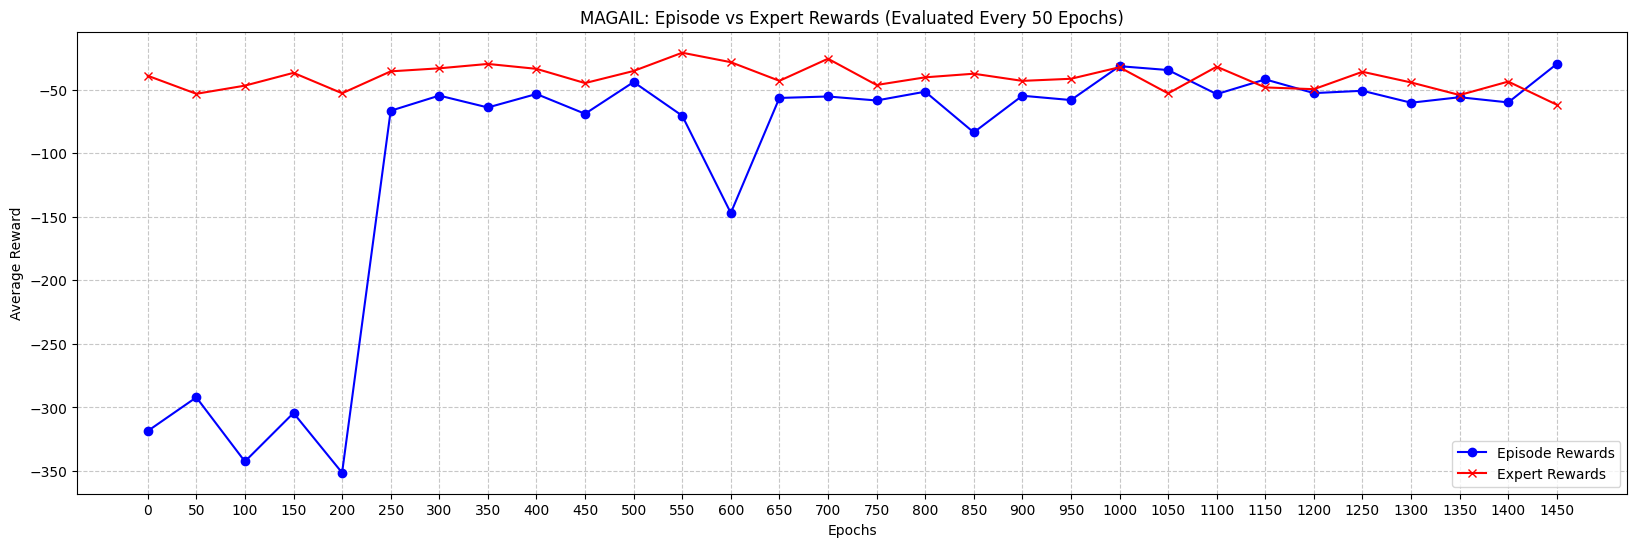

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Assuming these are your lists (replace with your actual data)
# Example data for demonstration

epochs = range(0, len(all_episode_rewards) * 50, 50)  # X-axis: epochs (0, 50, 100, ...)


# Create the plot
plt.figure(figsize=(20, 6))
plt.plot(epochs, all_episode_rewards, label='Episode Rewards', marker='o', color='blue')
plt.plot(epochs, all_expert_rewards, label='Expert Rewards', marker='x', color='red')

# Customize the plot
plt.xlabel('Epochs')
plt.ylabel('Average Reward')
plt.title('MAGAIL: Episode vs Expert Rewards (Evaluated Every 50 Epochs)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(epochs)  # Show epoch numbers on x-axis


# Save plot
os.makedirs("plots", exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
save_path = f"plots/magail_{timestamp}.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')


# Display the plot
plt.show()